In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
df = pd.read_csv('../OHLC/TSLA.csv')
df = df[::-1]
df = df.reset_index()
df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,3285,7/19/2023,296.040009,299.290009,289.519989,291.260010,291.260010,137849600
1,3284,7/18/2023,290.149994,295.260010,286.010010,293.339996,293.339996,112434700
2,3283,7/17/2023,286.630005,292.230011,283.570007,290.380005,290.380005,131569600
3,3282,7/14/2023,277.010010,285.299988,276.309998,281.380005,281.380005,119771100
4,3281,7/13/2023,274.589996,279.450012,270.600006,277.899994,277.899994,112681500


<Axes: >

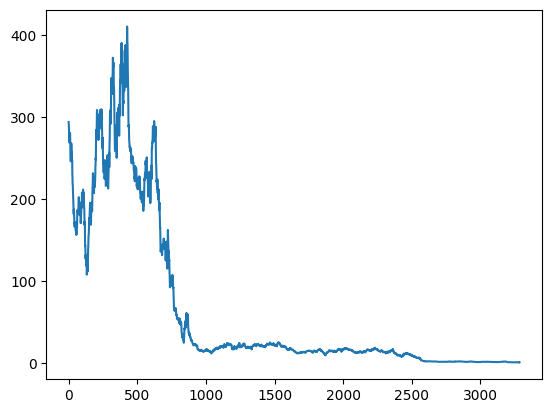

In [13]:
OHLC_avg = df[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
OHLC_avg.plot()

In [14]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [15]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [16]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [17]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
step_size = 1
model = Sequential()
model.add(
LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))

In [19]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/5
2462/2462 - 9s - loss: 0.0062 - 9s/epoch - 3ms/step
Epoch 2/5
2462/2462 - 6s - loss: 1.8485e-04 - 6s/epoch - 2ms/step
Epoch 3/5
2462/2462 - 5s - loss: 1.8151e-04 - 5s/epoch - 2ms/step
Epoch 4/5
2462/2462 - 5s - loss: 2.0184e-04 - 5s/epoch - 2ms/step
Epoch 5/5
2462/2462 - 5s - loss: 1.9964e-04 - 5s/epoch - 2ms/step
26/26 [==============================] - 0s 1ms/step


In [20]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Train RMSE: 4.52
Test RMSE: 2.28


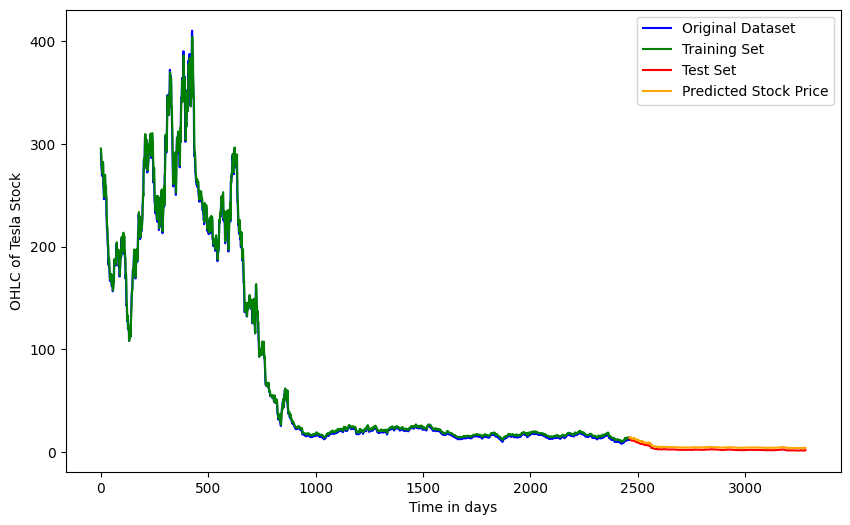

In [21]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# Plotting the graph
plt.figure(figsize=(10, 6))

# Plot original training data
plt.plot(trainY[0], label='Original Dataset', color='blue')

# Plot predicted training data
trainPredictPlot = np.empty_like(trainY[0])
trainPredictPlot[:] = np.nan
trainPredictPlot[:len(trainPredict)] = trainPredict[:, 0]
plt.plot(trainPredictPlot, label='Training Set', color='green')

# Plot original testing data
plt.plot(range(len(trainY[0]), len(trainY[0]) + len(testY[0])), testY[0], label='Test Set', color='red')

# Plot predicted testing data
testPredictPlot = np.empty_like(testY[0])
testPredictPlot[:] = np.nan
testPredictPlot[:len(testPredict)] = testPredict[:, 0]
plt.plot(range(len(trainY[0]), len(trainY[0]) + len(testPredict)), testPredictPlot, label='Predicted Stock Price', color='orange')

# Add labels and title
plt.xlabel('Time in days')
plt.ylabel('OHLC of Tesla Stock')
plt.legend()

# Show the plot
plt.show()